In [3]:
import sys
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from data_helper import *

config = configparser.ConfigParser()
config.read('config/mypredictorconfig.ini')

eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [4]:
# Model reconstruction from JSON file
weight_name = config['infiles']['weight_name']
arch_name = config['infiles']['arch_name']

with open(arch_name, 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(weight_name)



W0731 14:55:40.533349 4756592064 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 14:55:40.550893 4756592064 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 14:55:40.554346 4756592064 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 14:55:41.201553 4756592064 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name 

In [5]:
anomaly_threshold = int(config['MODEL']['anomaly_threshold'])
look_back = int(config['MODEL']['look_back'])

In [6]:
point_list = [point_name, 'aiTIT4045','Future_TMY','Outside_Air_Temp_Forecast']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df['aiTIT4045'].fillna(df['Outside_Air_Temp_Forecast'], inplace = True)
df['aiTIT4045'].fillna(df['Future_TMY'], inplace = True)
df.loc[(df['aiTIT4045'].pct_change() == 0.0 ), 'aiTIT4045'] = np.nan
df['aiTIT4045'].fillna(df['Outside_Air_Temp_Forecast'], inplace = True)
df['aiTIT4045'].fillna(df['Future_TMY'], inplace = True)
df.drop(['Outside_Air_Temp_Forecast','Future_TMY'], axis = 1, inplace = True)
start = df.shape[0]
df = df.dropna(how='any')
print(f"Removed: {start - df.shape[0]} rows")

Grabbing WebIDs ...
WebID collection complete!
14:55:45: Sending API request... Chunk 1 of 1
14:55:45: Response recieved for 4 tags! (0.1)
Removed: 0 rows


In [7]:
df = create_standard_multivariable_df(df, shift = look_back)

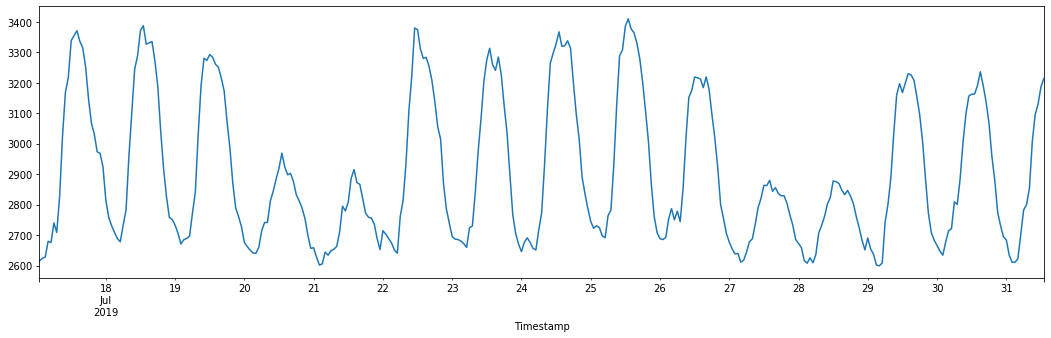

In [8]:
df[point_name].plot(figsize = (18,5))

In [9]:
y = df[point_name]
X = df.drop(columns=point_name)

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

X_test = scaler.fit_transform(X)
y_test = scaler.fit_transform(np.array(y).reshape((-1,1)))


In [11]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [12]:
prediction = model.predict(X_test)

In [13]:
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [14]:
prediction = prediction

In [15]:
index = df.index

<Figure size 1440x720 with 0 Axes>

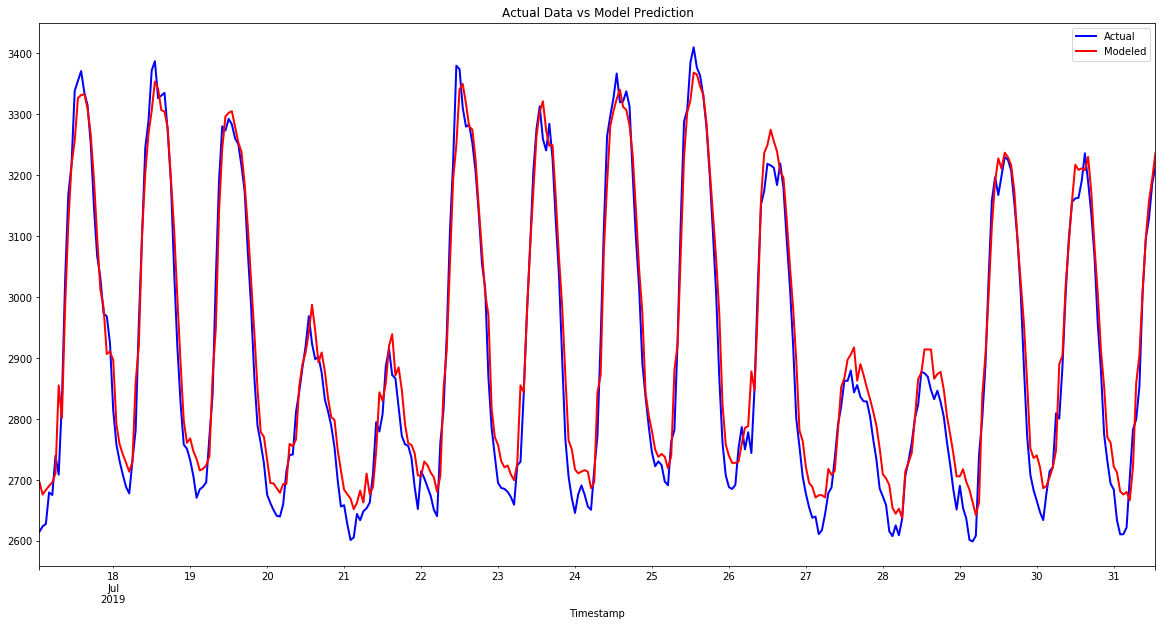

In [16]:
plt.figure(figsize=(20,10))
result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=index)

result.plot(figsize=(20,10),
                         title="Actual Data vs Model Prediction",
                         linewidth=2,
                         color=['blue','red'])

In [17]:
result.eval('Difference = (Actual - Modeled)/ Actual * 100', inplace=True)

#result["Difference"] = result['Actual'] - result['Modeled']
result["Difference"] = result['Difference'].abs().round(decimals = 2)

In [18]:
result.head()

,Actual,Modeled,Difference
Timestamp,,,
2019-07-17 01:00:00,2614.991353,2696.424561,3.11
2019-07-17 02:00:00,2623.946960,2676.024902,1.98
2019-07-17 03:00:00,2627.607707,2683.585449,2.13
2019-07-17 04:00:00,2679.489187,2690.059814,0.39
2019-07-17 05:00:00,2675.266215,2695.793213,0.77


In [19]:
actual = result['Actual'].tolist()
modeled = result['Modeled'].tolist()
difference = result['Difference'].tolist()
idx = result.index.tolist()
ymax = max(max(actual, modeled))
ymin = min(min(actual, modeled))

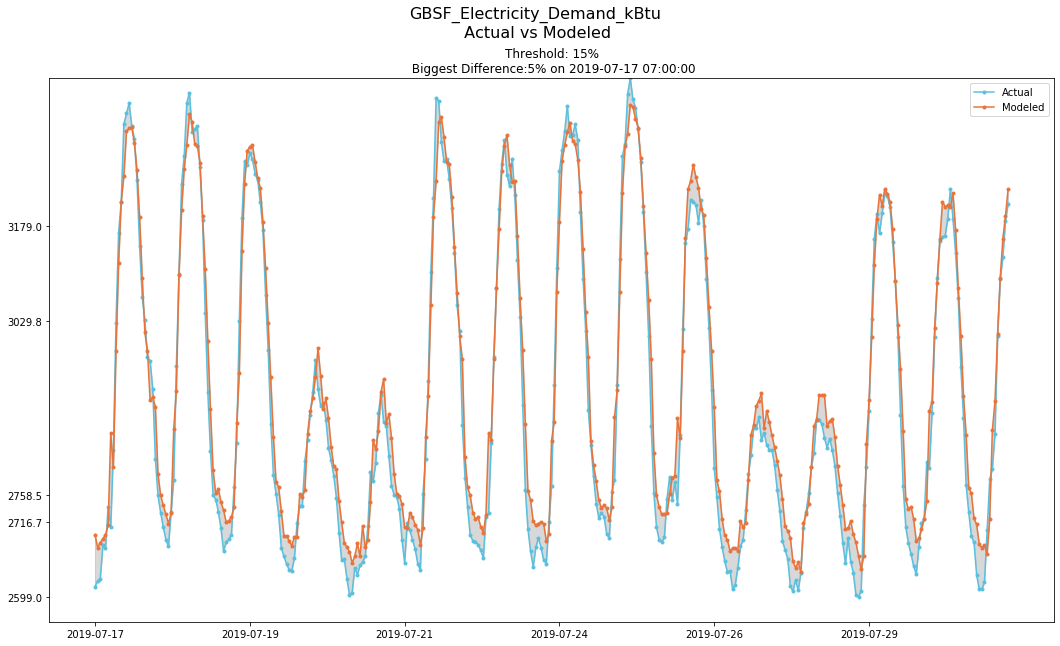

In [20]:
plt.figure(figsize=(18,10))
count = 1
for ii in range(len(actual)):
    
    if difference[ii] > anomaly_threshold:
        if count%2 == 0:
            plt.text(idx[ii] , ymin*0.99, int(difference[ii]), size = 11)
            count = count +1
        else:
            plt.text(idx[ii] , ymin*1.00, int(difference[ii]), size = 11)
            count = count +1
        plt.axvline(x = idx[ii], color = 'r', linestyle = '--')
plt.plot(idx, actual, marker = ".", color="#5bc0de", label = 'Actual')
plt.plot(idx, modeled, marker = ".", color="#E8743B", label = "Modeled")

plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(idx, actual, modeled, color = "grey", alpha = "0.3")
plt.yticks(actual, size= 10)
plt.xticks(idx, size = 10)

plt.locator_params(axis = 'y', tight = True, nbins=6)
plt.locator_params(axis = 'x', nbins = 6)
biggest_difference = result.loc[result['Difference'] == max(difference)]['Difference'][0]
at_time = result.loc[result['Difference'] == max(difference)].index[0]
plt.suptitle(f"{point_name}\n Actual vs Modeled", fontsize = 16)
plt.title(f"Threshold: {anomaly_threshold}%\n Biggest Difference:{int(biggest_difference)}% on {at_time}")
plt.legend()
plt.show()